In [16]:
pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 62.1 MB/s eta 0:00:00


In [17]:
import os
import pandas as pd
from datetime import datetime, time
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import numpy as np
import requests
import geopandas as gpd
import contextily as ctx

In [2]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

In [3]:
# read in data
all_trips = pd.read_csv('all_trip_data.csv')
snow_dates = pd.read_csv('snowdays_DEPTHBASED.csv')
control_dates = pd.read_csv('controldays_DEPTHBASED.csv')

# split alldata into dedup snow and dedup control, sort by date
dedup_snow = all_trips[all_trips['date'].isin(snow_dates['date'])].sort_values(by='date')
dedup_control = all_trips[all_trips['date'].isin(control_dates['date'])].sort_values(by='date')
print(dedup_snow.shape)
print(dedup_control.shape)

(40754, 15)
(44185, 15)


In [4]:
# map station ID's and coordiantes to station names
url = "https://transport.integration.sl.se/v1/stop-points"
headers = {
    'accept': 'application/json',
    'Content-Type': 'application/json',
    'expand': 'true',
    'Accept-Encoding': 'identity'
}
r_data = requests.get(url,headers=headers).json()
df_sites= pd.json_normalize(r_data)
stop_mappings = df_sites[['gid', 'name', 'lat', 'lon']]

dedup_snow = dedup_snow.merge(stop_mappings, left_on='stop_id', right_on='gid', how='left')
dedup_snow = dedup_snow.rename(columns={'name': 'stop_name'}).drop(columns='gid')
dedup_control = dedup_control.merge(stop_mappings, left_on='stop_id', right_on='gid', how='left')
dedup_control = dedup_control.rename(columns={'name': 'stop_name'}).drop(columns='gid')

## Number of Trips

In [5]:
def trips_per_day(df_snow, df_control):
    day_group_snow = df_snow.groupby('date').trip_day_id.count().reset_index(name='Snow days')
    day_group_control = df_control.groupby('date').trip_day_id.count().reset_index(name='Control days')
    merged = pd.merge(day_group_snow, day_group_control, on='date', how='outer').fillna(0).set_index('date').sort_values(by='date')
    merged.plot(kind='bar', figsize=(12, 4), title=f'Number of trips per day')
    plt.show()

def total_unique_trips(df_snow, df_control):
    print("Total trips - Snow days:", df_snow['trip_day_id'].nunique())
    print("Total trips - Control days:", df_control['trip_day_id'].nunique())

def avg_std_daily_trips(df_snow, df_control):
    day_counts_snow = df_snow.groupby('date')['trip_day_id'].nunique()
    day_counts_control = df_control.groupby('date')['trip_day_id'].nunique()
    print("Snow days - Avg trips per day:", round(day_counts_snow.mean(),2), ", Std:", round(day_counts_snow.std(), 2))
    print("Control days - Avg trips per day:", round(day_counts_control.mean(), 2), ", Std:", round(day_counts_control.std(), 2))

def trips_per_route_length(df_snow, df_control):
    lengths_snow = df_snow.groupby('trip_day_id')['stop_sequence'].nunique().reset_index(name='route_length')
    lengths_control = df_control.groupby('trip_day_id')['stop_sequence'].nunique().reset_index(name='route_length')
    count_snow = lengths_snow.groupby('route_length').trip_day_id.count().reset_index(name='Snow days')
    count_control = lengths_control.groupby('route_length').trip_day_id.count().reset_index(name='Control days')
    merged = pd.merge(count_snow, count_control, on='route_length', how='outer').fillna(0).set_index('route_length')
    print(merged)
    merged.plot(kind='bar', figsize=(8, 4), title='Trips per Route Length')
    plt.show()

def trips_per_weekday(df_snow, df_control):
    df_snow['weekday'] = pd.to_datetime(df_snow['date']).dt.day_name()
    df_control['weekday'] = pd.to_datetime(df_control['date']).dt.day_name()
    count_snow = df_snow.groupby('weekday')['trip_day_id'].nunique()
    count_control = df_control.groupby('weekday')['trip_day_id'].nunique()
    count_snow = count_snow.reindex(weekdays, fill_value=0)
    count_control = count_control.reindex(weekdays, fill_value=0)
    pd.DataFrame({'Snow days': count_snow, 'Control days': count_control}).plot(kind='bar', figsize=(8, 4), title='Trips per Day of Week')
    plt.show()

def trips_per_time_of_day(df_snow, df_control):
    df_snow['hour'] = pd.to_datetime(df_snow['arrival_time'], unit='s', utc=True).dt.tz_convert('Europe/Stockholm').dt.hour
    df_control['hour'] = pd.to_datetime(df_control['arrival_time'], unit='s', utc=True).dt.tz_convert('Europe/Stockholm').dt.hour
    count_snow = df_snow.groupby('hour')['trip_day_id'].nunique()
    count_control = df_control.groupby('hour')['trip_day_id'].nunique()
    all_hours = list(range(3, 10))
    count_snow = count_snow.reindex(all_hours, fill_value=0)
    count_control = count_control.reindex(all_hours, fill_value=0)
    pd.DataFrame({'Snow days': count_snow, 'Control days': count_control}).plot(kind='bar', figsize=(8, 4), title='Trips per Time of Day')
    plt.show()

def route_length_per_day(df_snow, df_control):
    lengths_snow = df_snow.groupby('date')['stop_sequence'].nunique().reset_index(name='route_length')
    lengths_control = df_control.groupby('date')['stop_sequence'].nunique().reset_index(name='route_length')
    merged = pd.merge(lengths_snow, lengths_control, on=['route_length', 'date'], how='outer').fillna(0).set_index('date').sort_values(by='date')
    merged.plot(kind='bar', figsize=(12, 4), title='Route Length per Day')
    plt.show()

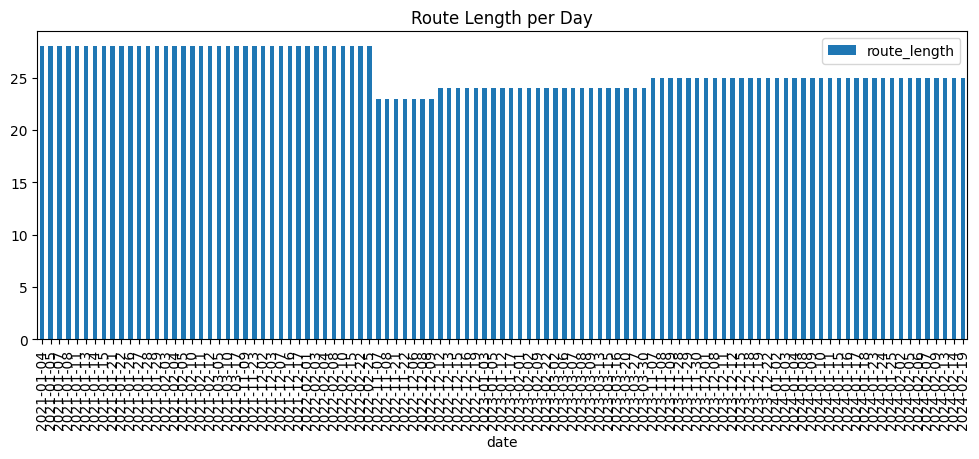

In [6]:
route_length_per_day(dedup_snow, dedup_control)

Total trips - Snow days: 1176
Total trips - Control days: 1273
Snow days - Avg trips per day: 30.9 , Std: 4.37
Control days - Avg trips per day: 31.74 , Std: 4.14


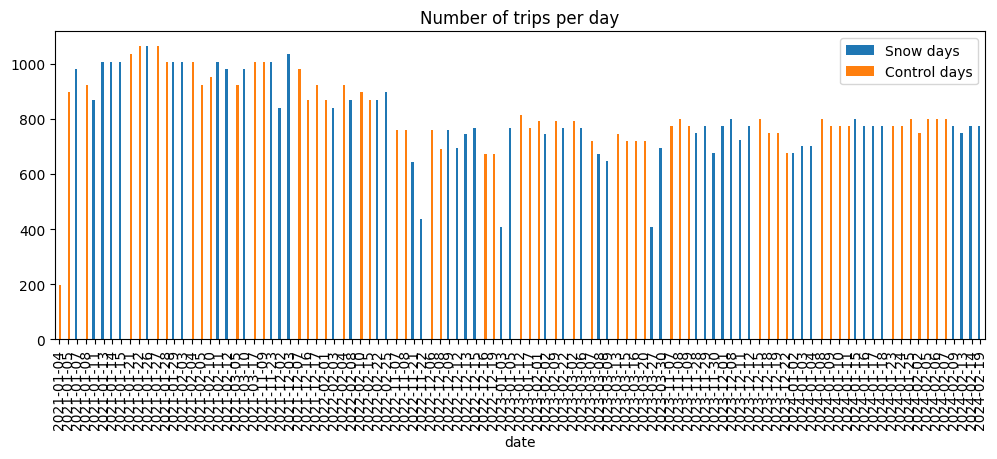

              Snow days  Control days
route_length                         
23                   31            51
24                  201           259
25                  509           529
28                  435           434


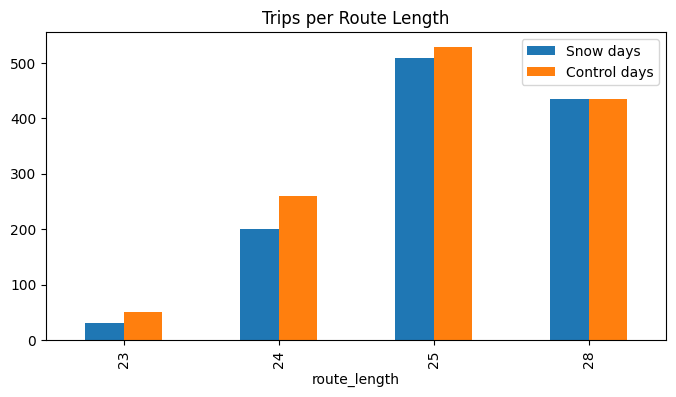

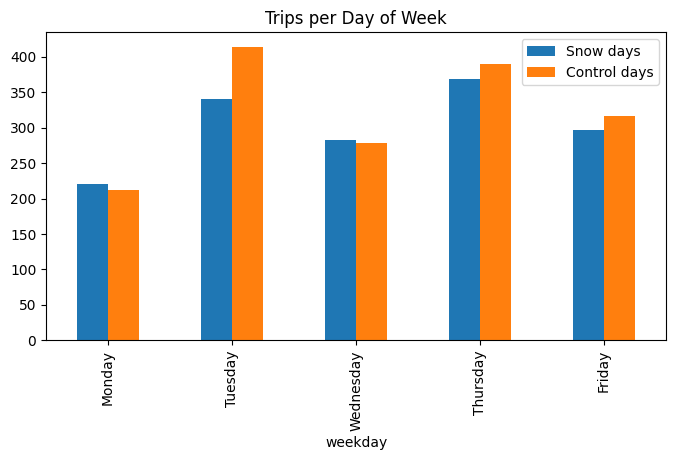

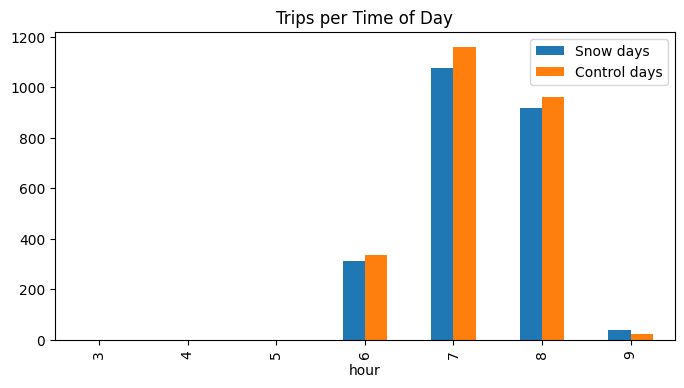

In [7]:
total_unique_trips(dedup_snow, dedup_control)
avg_std_daily_trips(dedup_snow, dedup_control)
trips_per_day(dedup_snow, dedup_control)
trips_per_route_length(dedup_snow, dedup_control)
trips_per_weekday(dedup_snow, dedup_control)
trips_per_time_of_day(dedup_snow, dedup_control)

## Arrival Delay

aggregation levels:
- row-level (trip x station)
- trip-level
- station-level
- date-level
- day of week -level
- time of day - level (hourly)

In [8]:
def delay_analysis(df_snow, df_control, variab):
    time_map = 'arrival_time' if variab == 'arrival_delay' else 'departure_time'
    df = pd.concat([df_snow.assign(day_type='Snow days'), df_control.assign(day_type='Control days')])
    df['hour'] = pd.to_datetime(df[time_map], unit='s', utc=True).dt.tz_convert('Europe/Stockholm').dt.hour
    df['weekday'] = pd.to_datetime(df['date']).dt.day_name()
    df['year'] = pd.to_datetime(df['date']).dt.year

    def print_stats(grouped, level_name):
        means = grouped[variab].mean()
        stds = grouped[variab].std()
        print(f"\nAverage {variab} and std - {level_name}:")
        print(pd.DataFrame({'mean': means, 'std': stds}))

    def print_ttest(grouped, level_name):
        print(f"\nT-tests for {level_name}:")
        for name, group in grouped:
            snow = group[group['day_type'] == 'Snow days'][variab].dropna()
            control = group[group['day_type'] == 'Control days'][variab].dropna()
            if len(snow) > 1 and len(control) > 1:
                stat, pval = ttest_ind(snow, control, equal_var=False)
                if level_name != 'Station level':
                    print(f"{name}: p = {pval:.4f}")
                elif pval >= 0.05:
                    print(f"{name}: p = {pval:.4f} (Insignificant station)")

    def plot_bar(grouped, level_name, title):
        means = grouped[variab].mean().unstack()
        stds = grouped[variab].std().unstack()

        # order by weekdays
        if title.split(" ")[-1] == 'Week':
            means = means.reindex(weekdays)
            stds = stds.reindex(weekdays)

        fig, ax = plt.subplots(figsize=(12, 4))
        x = np.arange(len(means))
        width = 0.35

        for i, col in enumerate(means.columns):
            offset = (i - 0.5) * width
            ax.bar(x + offset, means[col], width=width, label=col, yerr=stds[col], capsize=3, error_kw={'alpha': 0.2, 'elinewidth': 1.5})

        ax.set_title(title)
        ax.set_xticks(x)
        ax.set_xticklabels(means.index, rotation=90)
        ax.set_ylabel(f"Average {variab}")
        ax.legend()
        plt.show()

    def plot_hist(grouped, level_name, title):
        mean_delays = grouped[variab].mean().unstack()
        mean_delays.hist(bins=20, figsize=(12, 4))
        plt.suptitle(title)
        plt.show()

    print("\nAverage delay and std - Row level:")
    for label, d in df.groupby('day_type'):
        print(f"{label}: mean = {d[variab].mean():.2f}, std = {d[variab].std():.2f}")
    stat, pval = ttest_ind(df_snow[variab].dropna(), df_control[variab].dropna(), equal_var=False)
    print(f"\nT-tests for Row level: p = {pval:.4f}")

    trip_group = df.groupby(['trip_day_id', 'day_type'])
    print("\nAverage delay and std - Trip level:")
    for label, d in trip_group[variab].mean().reset_index().groupby('day_type'):
        print(f"{label}: mean = {d[variab].mean():.2f}, std = {d[variab].std():.2f}")
    plot_hist(trip_group, 'Trip Level', 'Histogram: Mean per Trip')

    date_group = df.groupby(['date', 'day_type'])
    print("\nAverage delay and std - Date level:")
    for label, d in date_group[variab].mean().reset_index().groupby('day_type'):
        print(f"{label}: mean = {d[variab].mean():.2f}, std = {d[variab].std():.2f}")
    plot_hist(date_group, 'Trip Level', 'Histogram: Mean per Date')

    station_group = df.groupby(['stop_name', 'day_type'])
    print_ttest(df.groupby('stop_name'), 'Station level')
    plot_bar(station_group, "Station level", "Mean per Station")

    station_group = df.groupby(['stop_sequence', 'day_type'])
    plot_bar(station_group, "Station level", "Mean per Stop Sequence")

    date_group = df.groupby(['date', 'day_type'])
    plot_bar(date_group, "Date level", "Mean per Date")

    weekday_group = df.groupby(['weekday', 'day_type'])
    print_stats(weekday_group, "Weekday level")
    print_ttest(df.groupby('weekday'), 'Weekday level')
    plot_bar(weekday_group, "Weekday level", "Mean by Day of Week")

    hour_group = df.groupby(['hour', 'day_type'])
    print_stats(hour_group, "Hourly level")
    print_ttest(df.groupby('hour'), 'Hourly level')
    plot_bar(hour_group, "Hourly level", "Mean by Hour of Day")

    year_group = df.groupby(['year', 'day_type'])
    print_stats(year_group, "Yearly level")
    print_ttest(df.groupby('year'), 'Yearly level')
    plot_bar(year_group, "Yearly level", "Mean by Year")




Average delay and std - Row level:
Control days: mean = 135.47, std = 169.82
Snow days: mean = 194.28, std = 336.72

T-tests for Row level: p = 0.0000

Average delay and std - Trip level:
Control days: mean = 130.92, std = 124.25
Snow days: mean = 187.86, std = 212.77


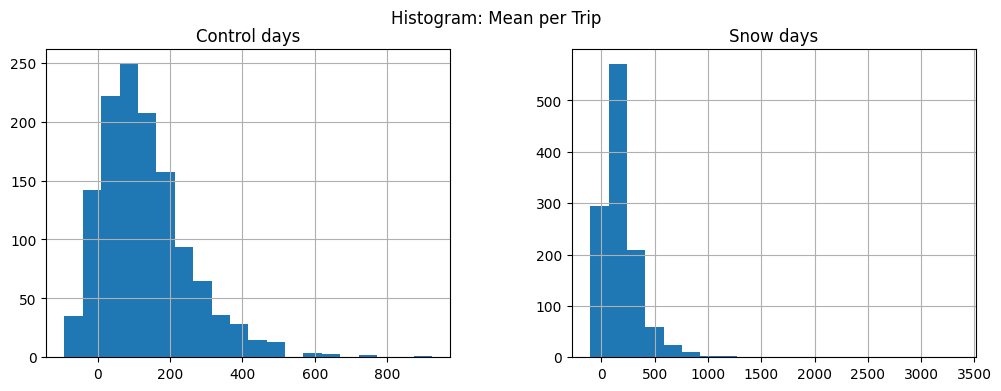


Average delay and std - Date level:
Control days: mean = 133.61, std = 54.48
Snow days: mean = 206.46, std = 190.80


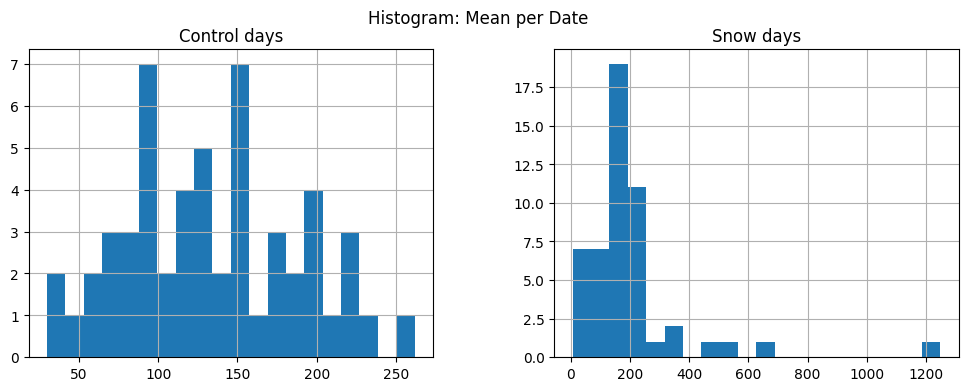


T-tests for Station level:


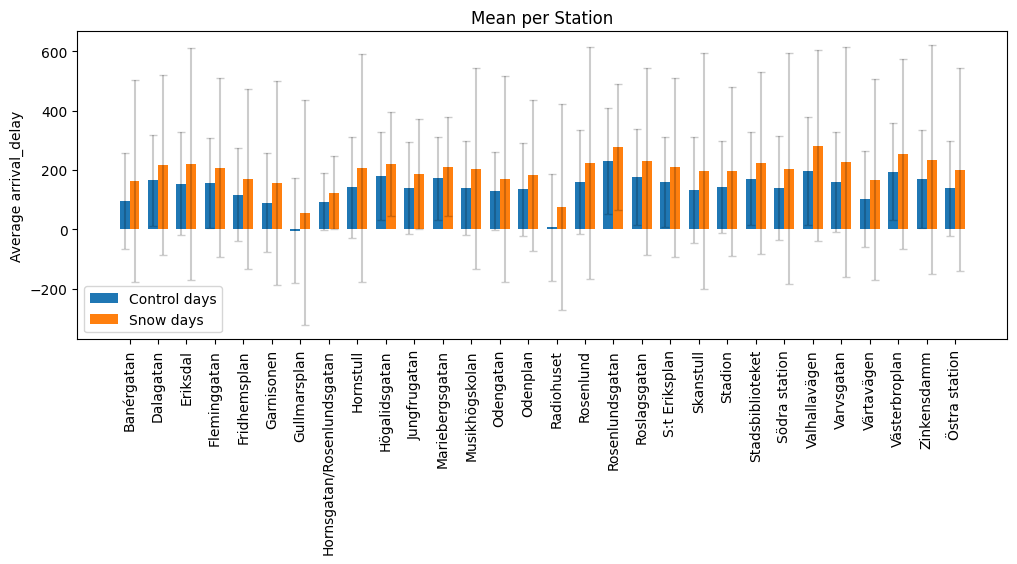

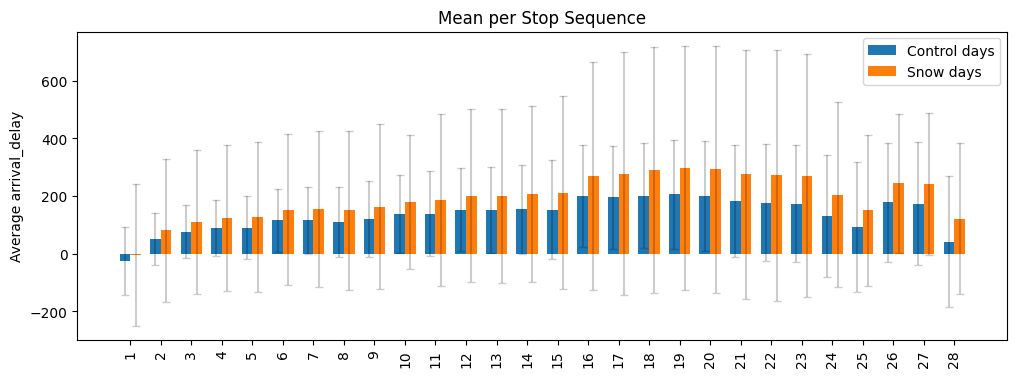

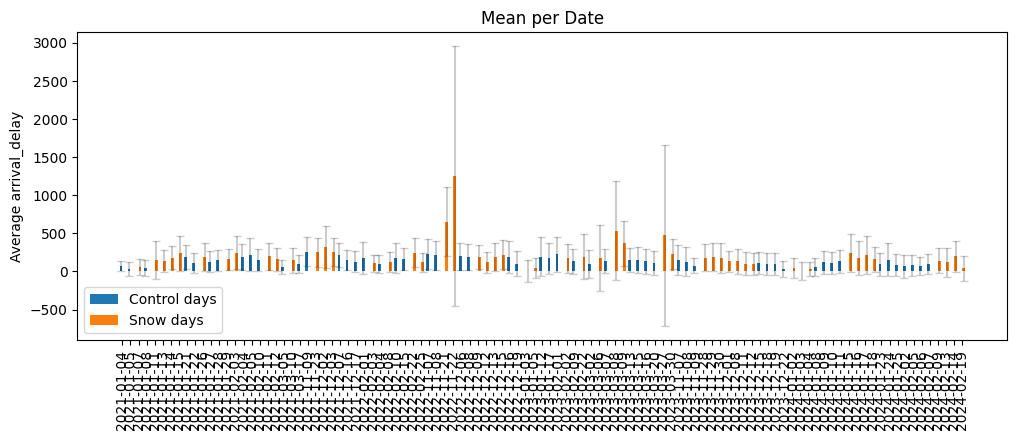


Average arrival_delay and std - Weekday level:
                              mean         std
weekday   day_type                            
Friday    Control days  105.664724  155.441712
          Snow days     173.415329  171.505114
Monday    Control days  116.851865  160.576810
          Snow days     222.526742  457.712726
Thursday  Control days  148.741891  171.936161
          Snow days     172.299522  203.929924
Tuesday   Control days  153.081297  177.975161
          Snow days     213.009209  476.867259
Wednesday Control days  136.605777  170.317558
          Snow days     203.118349  299.228654

T-tests for Weekday level:
Friday: p = 0.0000
Monday: p = 0.0000
Thursday: p = 0.0000
Tuesday: p = 0.0000
Wednesday: p = 0.0000


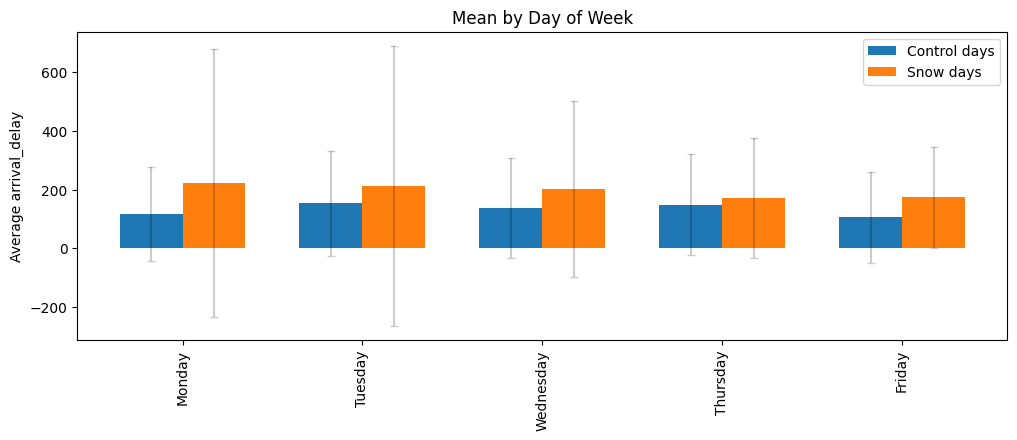


Average arrival_delay and std - Hourly level:
                          mean         std
hour day_type                             
6    Control days    74.015421  105.039549
     Snow days      126.843056  411.773412
7    Control days   133.128188  153.913954
     Snow days      169.962012  218.060060
8    Control days   148.295421  193.251483
     Snow days      230.218197  418.378186
9    Control days   332.808511  387.555530
     Snow days     1184.669811  986.223154

T-tests for Hourly level:
6: p = 0.0000
7: p = 0.0000
8: p = 0.0000
9: p = 0.0000


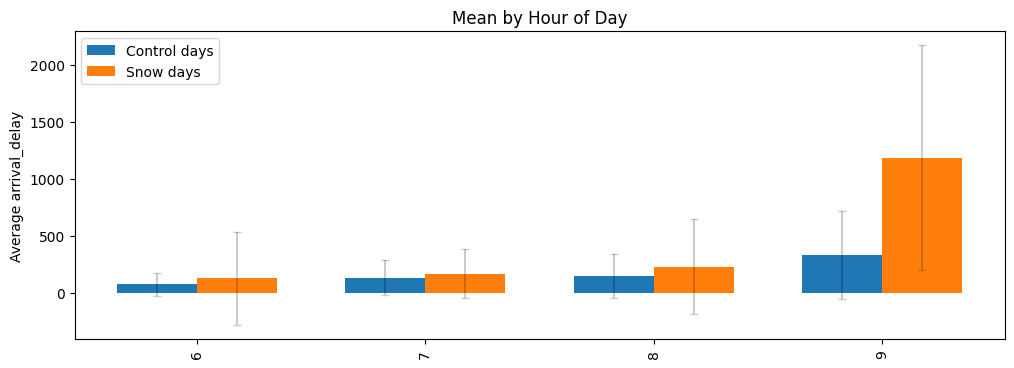


Average arrival_delay and std - Yearly level:
                         mean         std
year day_type                            
2021 Control days  142.419237  159.271346
     Snow days     192.059113  196.021909
2022 Control days  172.133342  182.158804
     Snow days     270.144282  535.708757
2023 Control days  130.433651  179.889191
     Snow days     193.849216  369.292033
2024 Control days   97.642203  150.970353
     Snow days     129.618127  200.665243

T-tests for Yearly level:
2021: p = 0.0000
2022: p = 0.0000
2023: p = 0.0000
2024: p = 0.0000


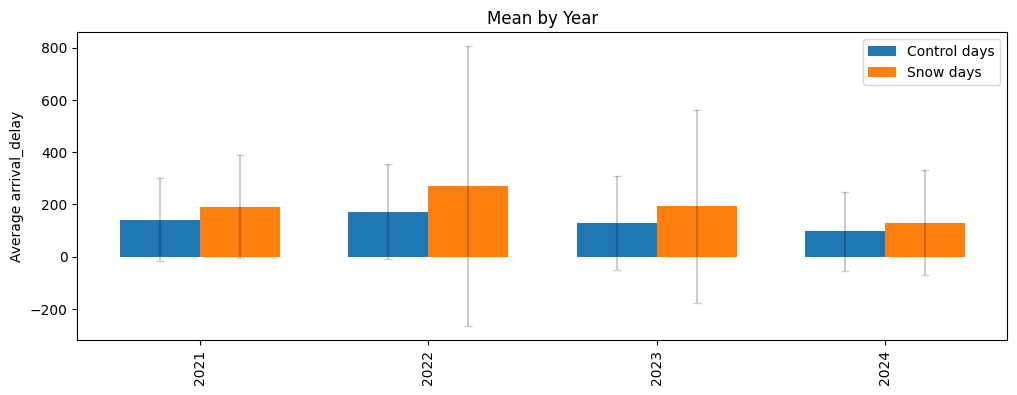

In [9]:
delay_analysis(dedup_snow, dedup_control, 'arrival_delay')


Average delay and std - Row level:
Control days: mean = 159.71, std = 169.17
Snow days: mean = 218.94, std = 337.36

T-tests for Row level: p = 0.0000

Average delay and std - Trip level:
Control days: mean = 155.66, std = 125.04
Snow days: mean = 212.92, std = 214.99


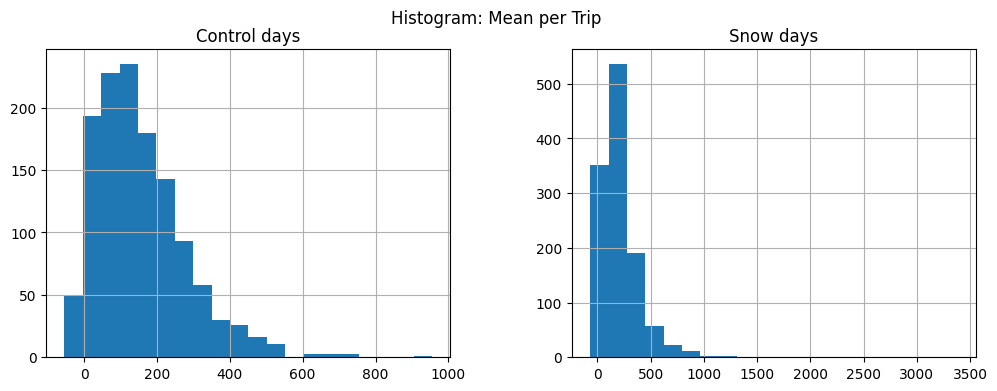


Average delay and std - Date level:
Control days: mean = 157.93, std = 54.69
Snow days: mean = 231.51, std = 192.38


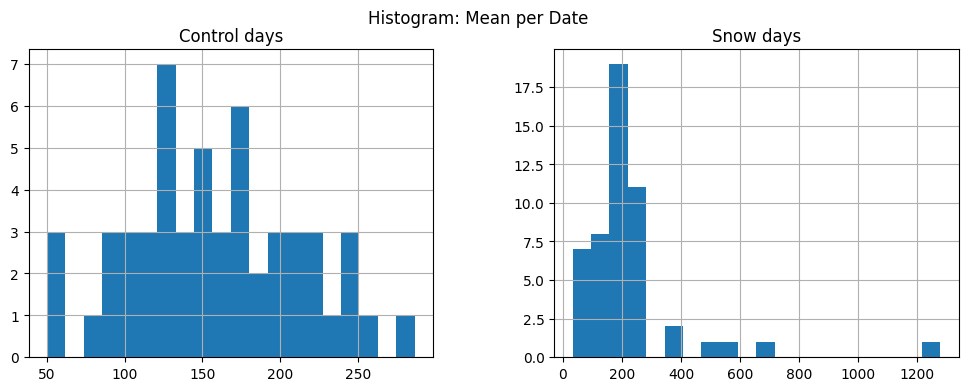


T-tests for Station level:


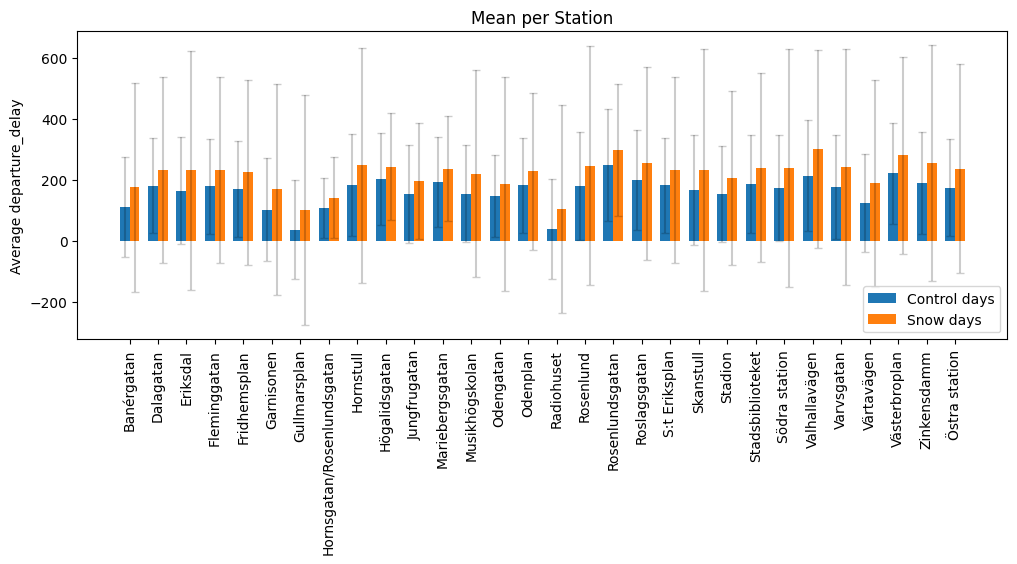

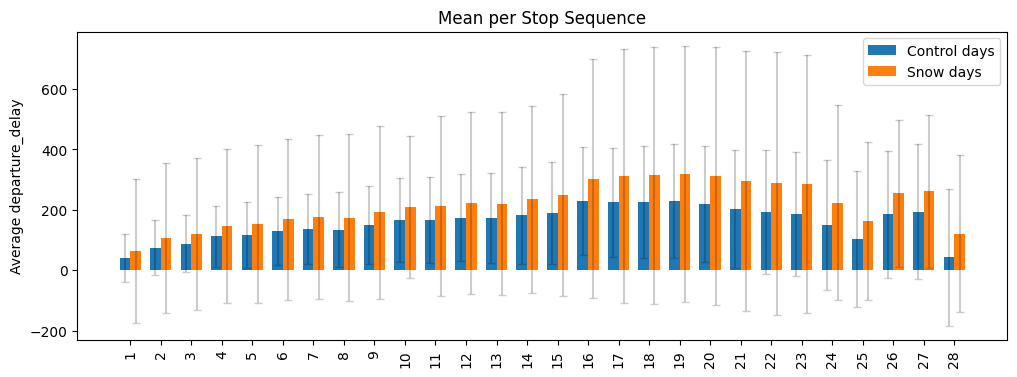

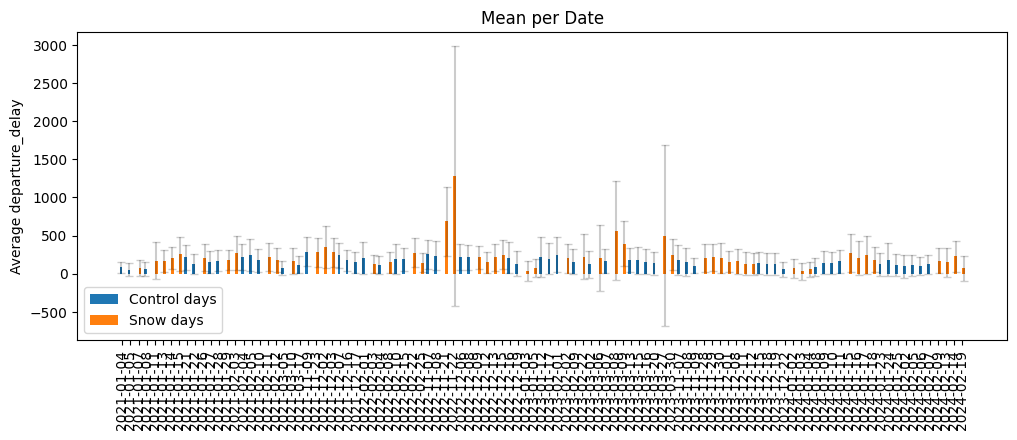


Average departure_delay and std - Weekday level:
                              mean         std
weekday   day_type                            
Friday    Control days  127.510197  154.088858
          Snow days     196.617270  171.920804
Monday    Control days  142.567727  158.905071
          Snow days     249.906228  459.110102
Thursday  Control days  173.091108  171.384696
          Snow days     195.414067  204.565766
Tuesday   Control days  177.866012  177.700788
          Snow days     238.719469  477.174525
Wednesday Control days  161.529925  169.814533
          Snow days     228.158960  299.492467

T-tests for Weekday level:
Friday: p = 0.0000
Monday: p = 0.0000
Thursday: p = 0.0000
Tuesday: p = 0.0000
Wednesday: p = 0.0000


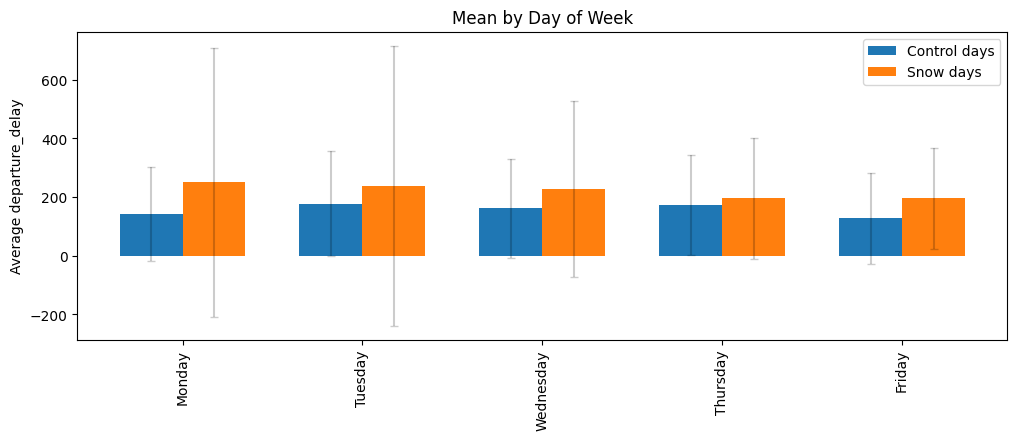


Average departure_delay and std - Hourly level:
                          mean         std
hour day_type                             
6    Control days    97.949828   87.194008
     Snow days      150.827146  413.538820
7    Control days   157.221088  152.484866
     Snow days      194.385416  217.841549
8    Control days   172.371341  194.287661
     Snow days      254.366109  418.218048
9    Control days   341.471698  368.557824
     Snow days     1166.345133  994.404297

T-tests for Hourly level:
6: p = 0.0000
7: p = 0.0000
8: p = 0.0000
9: p = 0.0000


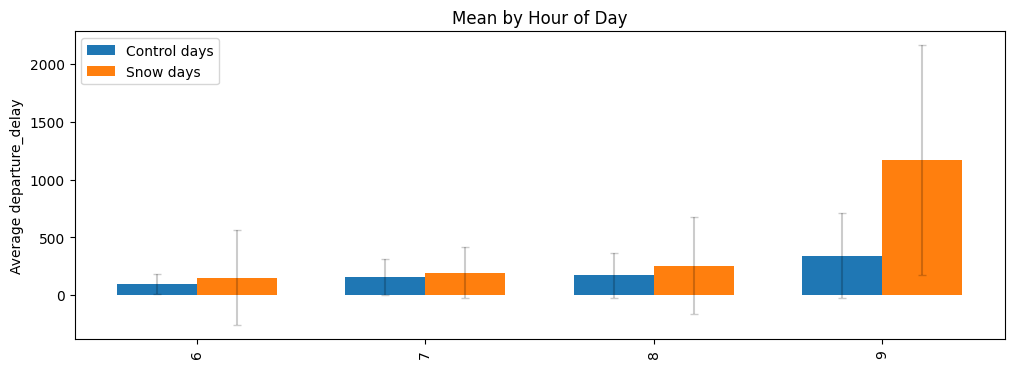


Average departure_delay and std - Yearly level:
                         mean         std
year day_type                            
2021 Control days  163.789637  159.472614
     Snow days     214.240220  197.120877
2022 Control days  195.062921  182.572107
     Snow days     294.658245  537.891712
2023 Control days  156.354017  178.555360
     Snow days     220.005199  368.758819
2024 Control days  125.504928  150.171540
     Snow days     156.530514  200.864596

T-tests for Yearly level:
2021: p = 0.0000
2022: p = 0.0000
2023: p = 0.0000
2024: p = 0.0000


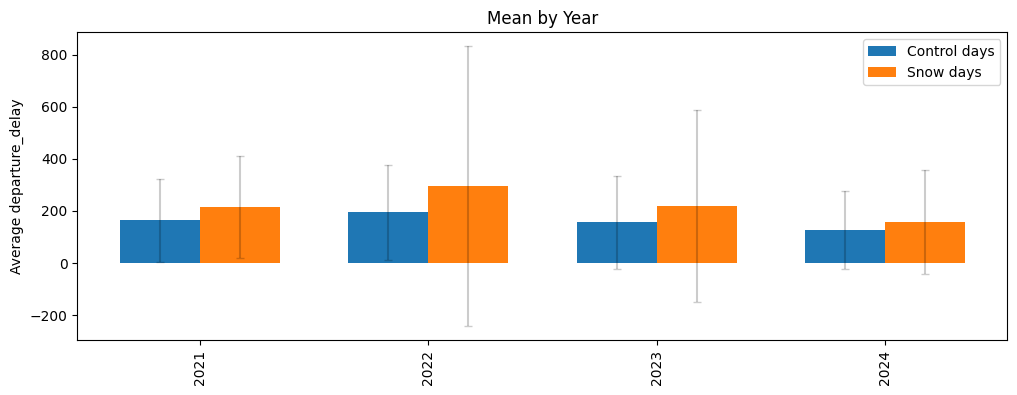

In [10]:
delay_analysis(dedup_snow, dedup_control, 'departure_delay')

# Additional delay vars

In [11]:
# calc additional fields
def calc_additional_delay_fields(test):
    # dwell time
    test['dwell_time'] = test['departure_time'] - test['arrival_time']
    # original delay
    test['origin_delay'] = test.groupby('trip_day_id')['arrival_delay'].transform(lambda x: x.iloc[0])
    # additional delay at each station
    test['arrival_delay_non_cumulative'] = test.groupby('trip_day_id')['arrival_delay'].diff().fillna(0)
    test.loc[test['stop_sequence'] == 1, 'arrival_delay_non_cumulative'] = 0
    return test

In [12]:
dedup_snow = calc_additional_delay_fields(dedup_snow)
dedup_control = calc_additional_delay_fields(dedup_control)


Average delay and std - Row level:
Control days: mean = 24.24, std = 33.28
Snow days: mean = 24.66, std = 36.04

T-tests for Row level: p = 0.0816

Average delay and std - Trip level:
Control days: mean = 24.74, std = 6.48
Snow days: mean = 25.07, std = 7.26


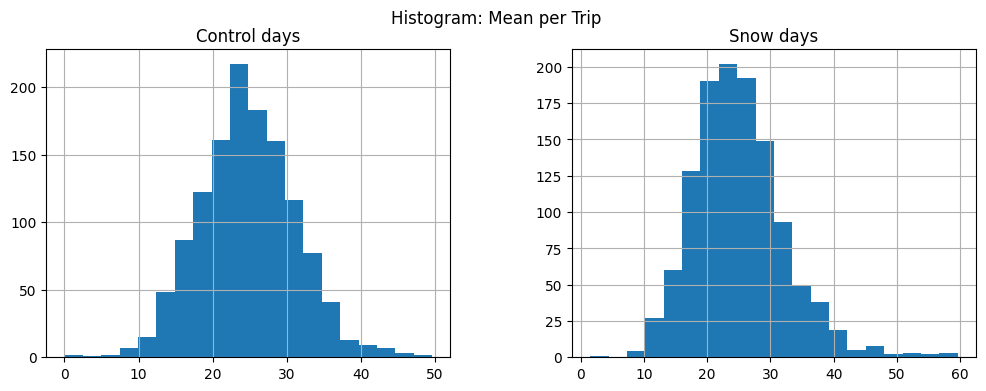


Average delay and std - Date level:
Control days: mean = 24.32, std = 3.28
Snow days: mean = 25.05, std = 3.77


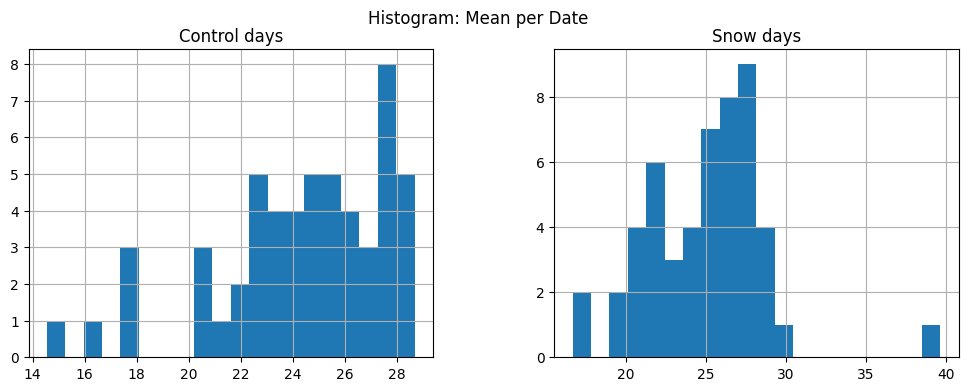


T-tests for Station level:
Banérgatan: p = 0.8427 (Insignificant station)
Dalagatan: p = 0.0539 (Insignificant station)
Eriksdal: p = 0.1320 (Insignificant station)
Fleminggatan: p = 0.4224 (Insignificant station)
Fridhemsplan: p = 0.6138 (Insignificant station)
Garnisonen: p = 0.8617 (Insignificant station)
Gullmarsplan: p = 0.1330 (Insignificant station)
Hornsgatan/Rosenlundsgatan: p = 0.3590 (Insignificant station)
Hornstull: p = 0.4865 (Insignificant station)
Högalidsgatan: p = 0.8386 (Insignificant station)
Jungfrugatan: p = 0.1559 (Insignificant station)
Mariebergsgatan: p = 0.0786 (Insignificant station)
Musikhögskolan: p = 0.0717 (Insignificant station)
Odengatan: p = 0.1374 (Insignificant station)
Odenplan: p = 0.8841 (Insignificant station)
Radiohuset: p = 0.3993 (Insignificant station)
Rosenlund: p = 0.1457 (Insignificant station)
Rosenlundsgatan: p = 0.2328 (Insignificant station)
Roslagsgatan: p = 0.6691 (Insignificant station)
S:t Eriksplan: p = 0.8561 (Insignificant sta

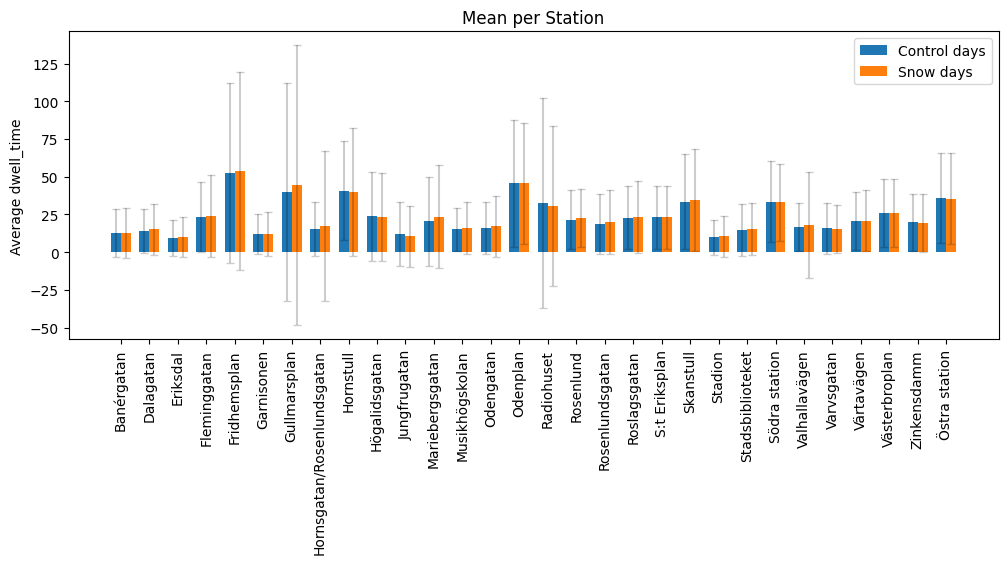

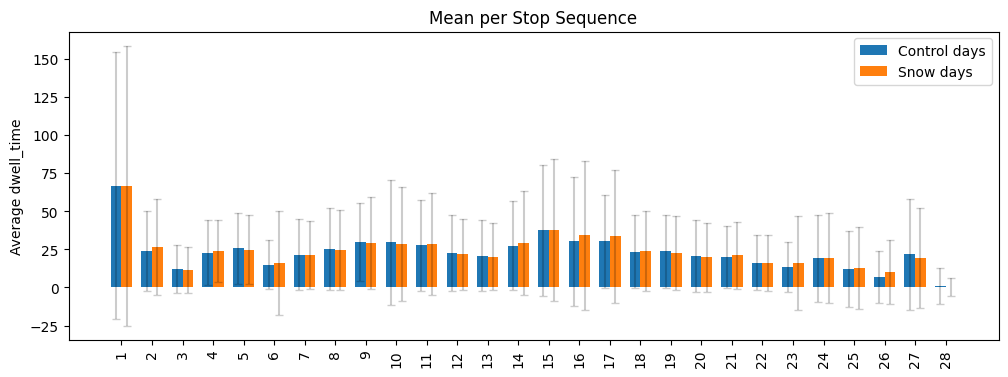

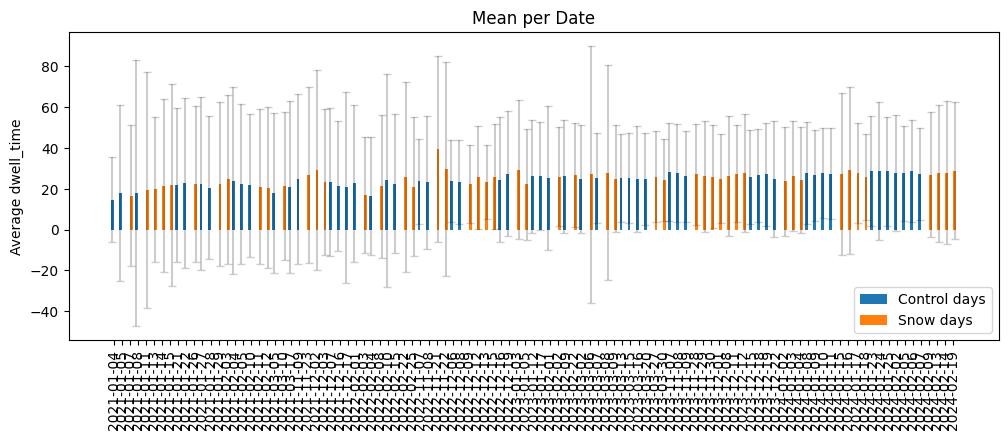


Average dwell_time and std - Weekday level:
                             mean        std
weekday   day_type                          
Friday    Control days  21.845473  40.039466
          Snow days     23.201941  35.463768
Monday    Control days  25.715861  23.978233
          Snow days     27.379486  43.288922
Thursday  Control days  24.349216  33.241402
          Snow days     23.114545  32.073720
Tuesday   Control days  24.784714  31.569494
          Snow days     25.710261  36.435081
Wednesday Control days  24.924148  33.050630
          Snow days     25.040611  35.172152

T-tests for Weekday level:
Friday: p = 0.0206
Monday: p = 0.0117
Thursday: p = 0.0057
Tuesday: p = 0.0548
Wednesday: p = 0.8338


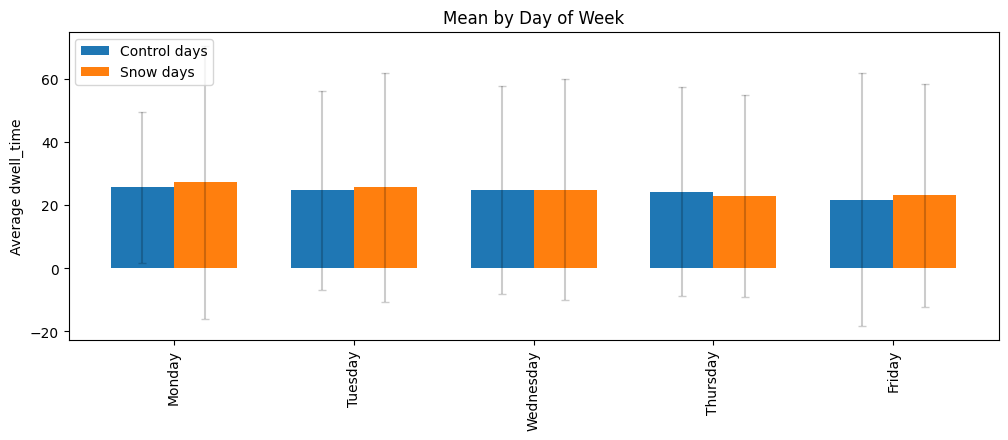


Average dwell_time and std - Hourly level:
                        mean        std
hour day_type                          
6    Control days  21.819588  36.917234
     Snow days     21.938902  40.091097
7    Control days  24.636559  35.528673
     Snow days     25.048863  37.278368
8    Control days  24.136629  29.417861
     Snow days     24.586970  33.648729
9    Control days  22.396226  34.663403
     Snow days     24.442478  40.698135

T-tests for Hourly level:
6: p = 0.9090
7: p = 0.2331
8: p = 0.1856
9: p = 0.7383


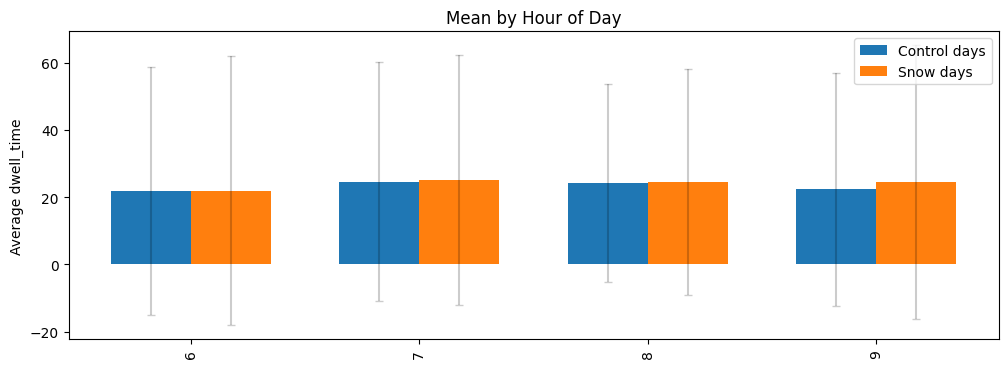


Average dwell_time and std - Yearly level:
                        mean        std
year day_type                          
2021 Control days  21.370400  42.031235
     Snow days     22.181107  41.857802
2022 Control days  22.929579  33.005168
     Snow days     24.513963  34.422804
2023 Control days  25.920366  25.427522
     Snow days     26.155984  31.996633
2024 Control days  27.862725  25.525156
     Snow days     26.912387  31.620654

T-tests for Yearly level:
2021: p = 0.1024
2022: p = 0.0036
2023: p = 0.5316
2024: p = 0.0320


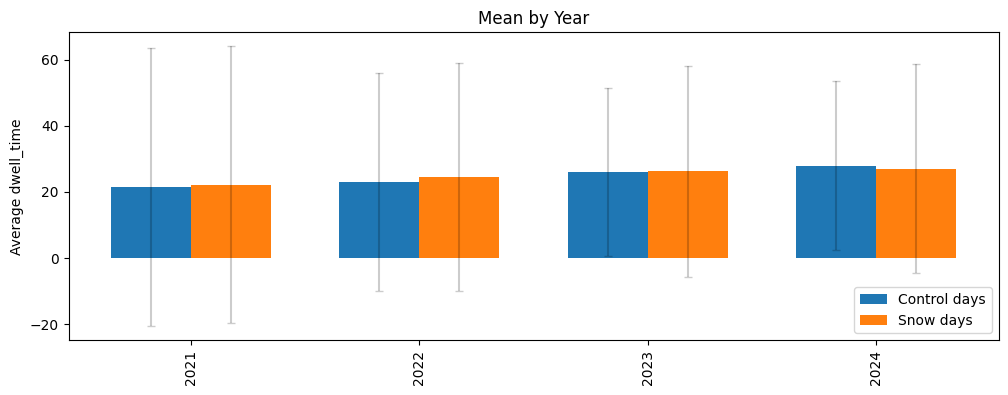

In [13]:
delay_analysis(dedup_snow, dedup_control, 'dwell_time')


Average delay and std - Row level:
Control days: mean = 96.89, std = 179.82
Snow days: mean = 153.13, std = 409.60

T-tests for Row level: p = 0.0000

Average delay and std - Trip level:
Control days: mean = 94.35, std = 177.31
Snow days: mean = 142.72, std = 357.05


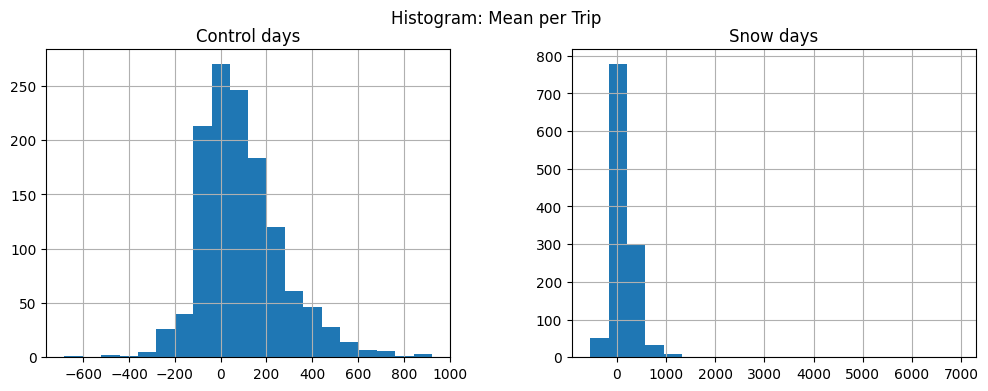


Average delay and std - Date level:
Control days: mean = 95.72, std = 54.06
Snow days: mean = 159.98, std = 182.74


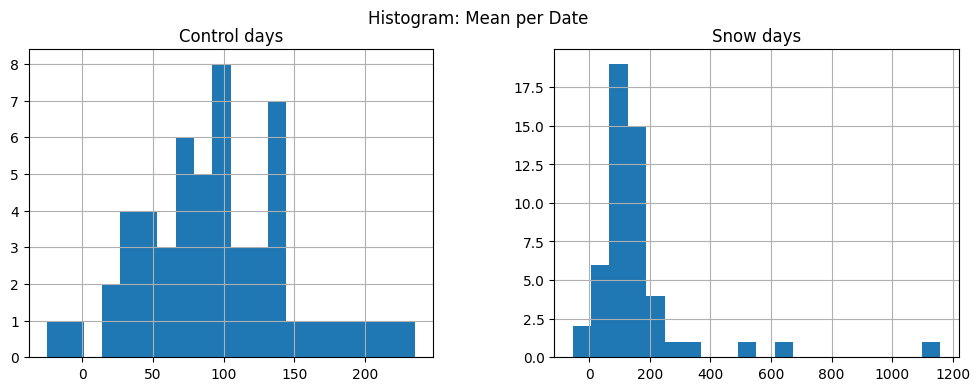


T-tests for Station level:


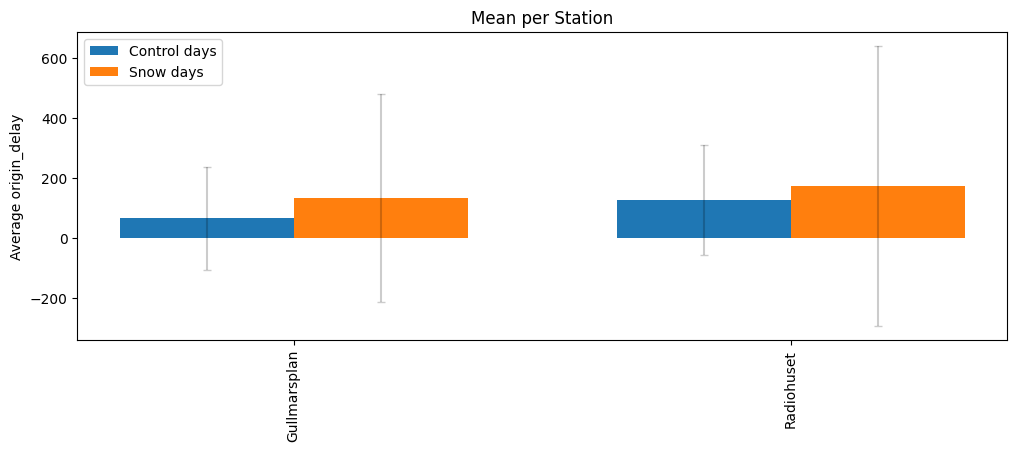

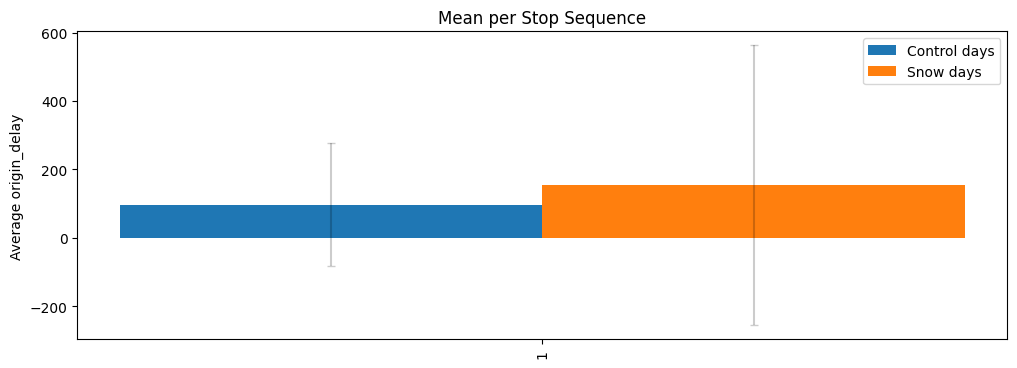

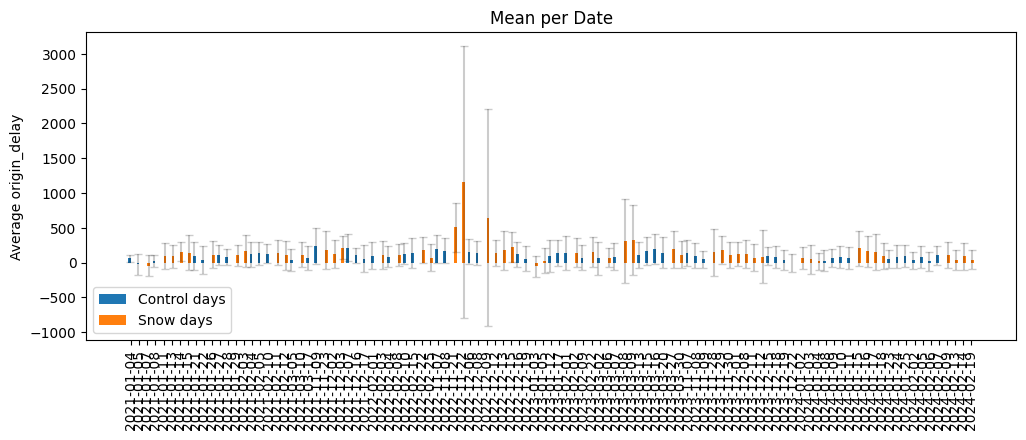


Average origin_delay and std - Weekday level:
                              mean         std
weekday   day_type                            
Friday    Control days   61.687500  159.090349
          Snow days     181.891089  564.226428
Monday    Control days   96.982063  183.047007
          Snow days     161.104803  257.462972
Thursday  Control days   98.511737  178.798529
          Snow days     116.284653  232.404703
Tuesday   Control days  112.866071  193.914416
          Snow days     174.113636  554.803154
Wednesday Control days  108.343434  173.702866
          Snow days     142.590278  277.990046

T-tests for Weekday level:
Friday: p = 0.0004
Monday: p = 0.0024
Thursday: p = 0.2190
Tuesday: p = 0.0485
Wednesday: p = 0.0756


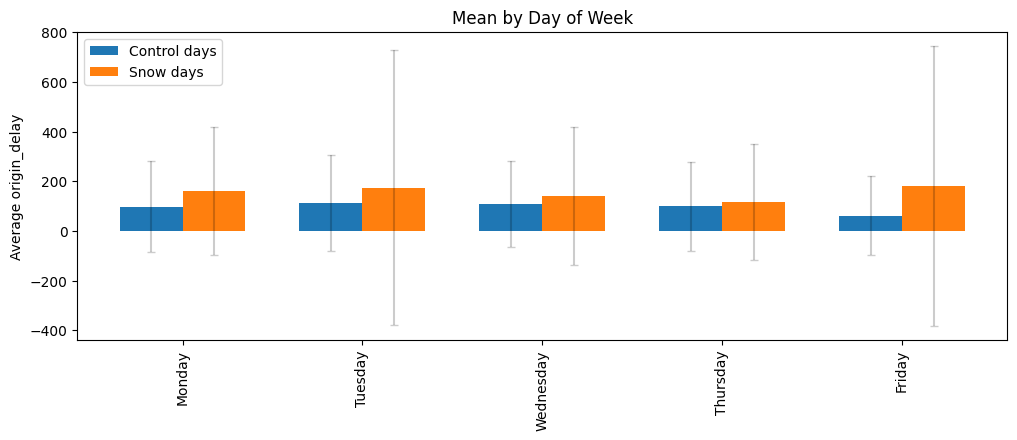


Average origin_delay and std - Hourly level:
                         mean         std
hour day_type                            
6    Control days   90.126437  164.722668
     Snow days     178.136646  581.705726
7    Control days   98.683938  182.613620
     Snow days     143.233209  318.535810
8    Control days   98.245192  188.700316
     Snow days     167.214286  507.458627

T-tests for Hourly level:
6: p = 0.0092
7: p = 0.0001
8: p = 0.0847


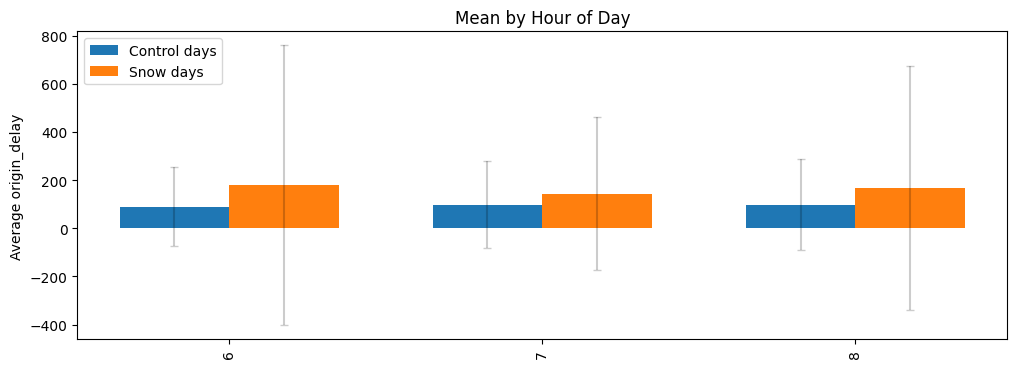


Average origin_delay and std - Yearly level:
                         mean         std
year day_type                            
2021 Control days   94.835227  180.644296
     Snow days     123.192698  200.943935
2022 Control days  129.823718  183.807054
     Snow days     300.047297  788.785390
2023 Control days  100.586011  192.419357
     Snow days     132.195175  294.354685
2024 Control days   64.600000  146.947970
     Snow days      95.196375  200.507358

T-tests for Yearly level:
2021: p = 0.0182
2022: p = 0.0003
2023: p = 0.0503
2024: p = 0.0245


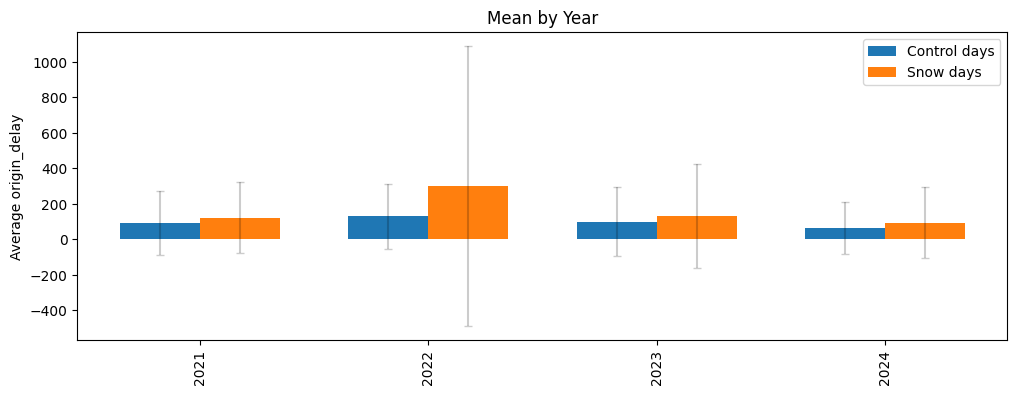

In [14]:
delay_analysis(dedup_snow[dedup_snow.stop_sequence ==1], dedup_control[dedup_control.stop_sequence ==1], 'origin_delay')


Average delay and std - Row level:
Control days: mean = 4.09, std = 83.48
Snow days: mean = 5.30, std = 128.53

T-tests for Row level: p = 0.1062

Average delay and std - Trip level:
Control days: mean = 3.98, std = 7.01
Snow days: mean = 5.17, std = 10.83


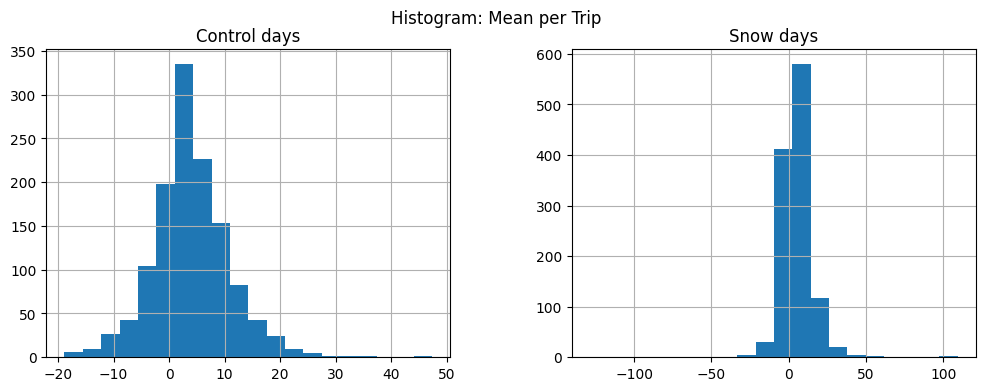


Average delay and std - Date level:
Control days: mean = 4.01, std = 2.04
Snow days: mean = 5.65, std = 5.28


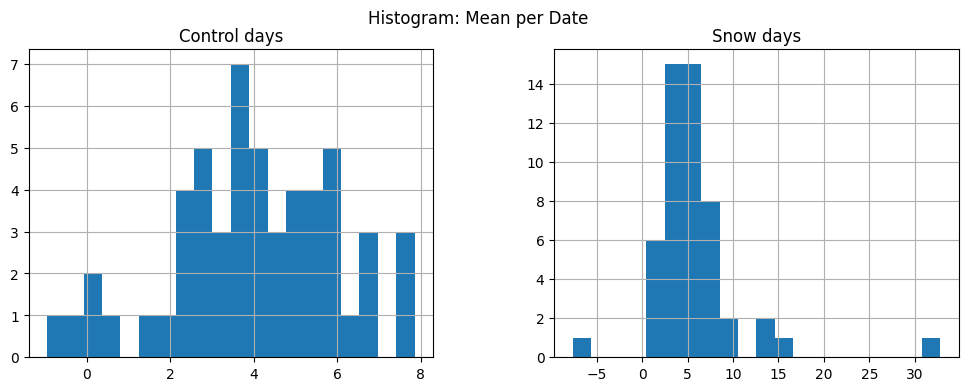


T-tests for Station level:
Banérgatan: p = 0.8719 (Insignificant station)
Dalagatan: p = 0.2237 (Insignificant station)
Eriksdal: p = 0.5213 (Insignificant station)
Fleminggatan: p = 0.7061 (Insignificant station)
Fridhemsplan: p = 0.5097 (Insignificant station)
Garnisonen: p = 0.8997 (Insignificant station)
Hornsgatan/Rosenlundsgatan: p = 0.2790 (Insignificant station)
Hornstull: p = 0.2984 (Insignificant station)
Högalidsgatan: p = 0.9290 (Insignificant station)
Jungfrugatan: p = 0.5859 (Insignificant station)
Mariebergsgatan: p = 0.9481 (Insignificant station)
Musikhögskolan: p = 0.8356 (Insignificant station)
Odengatan: p = 0.5913 (Insignificant station)
Odenplan: p = 0.0753 (Insignificant station)
Rosenlundsgatan: p = 0.5807 (Insignificant station)
S:t Eriksplan: p = 0.3790 (Insignificant station)
Skanstull: p = 0.4963 (Insignificant station)
Stadion: p = 0.6362 (Insignificant station)
Stadsbiblioteket: p = 0.8367 (Insignificant station)
Södra station: p = 0.9566 (Insignificant s

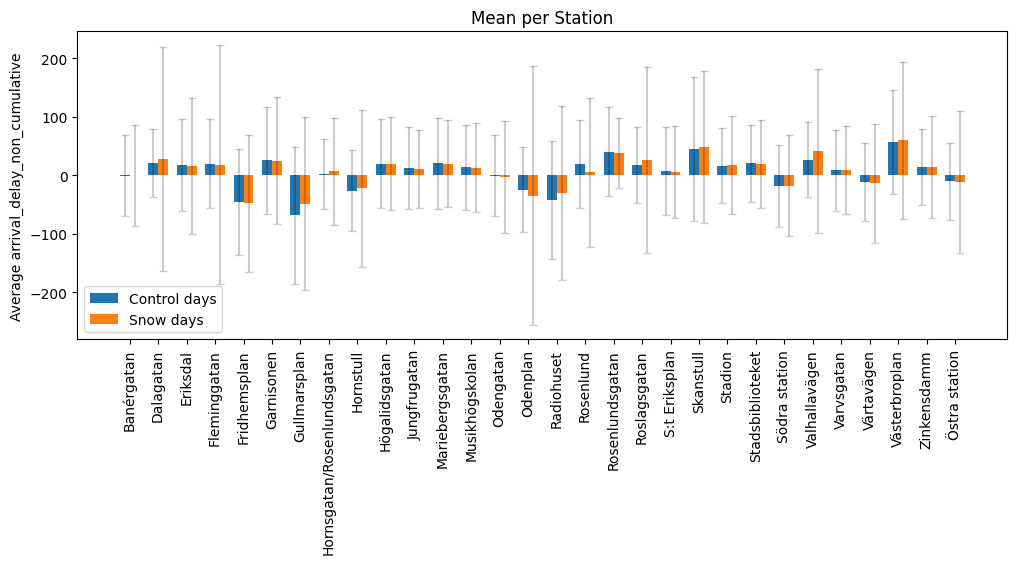

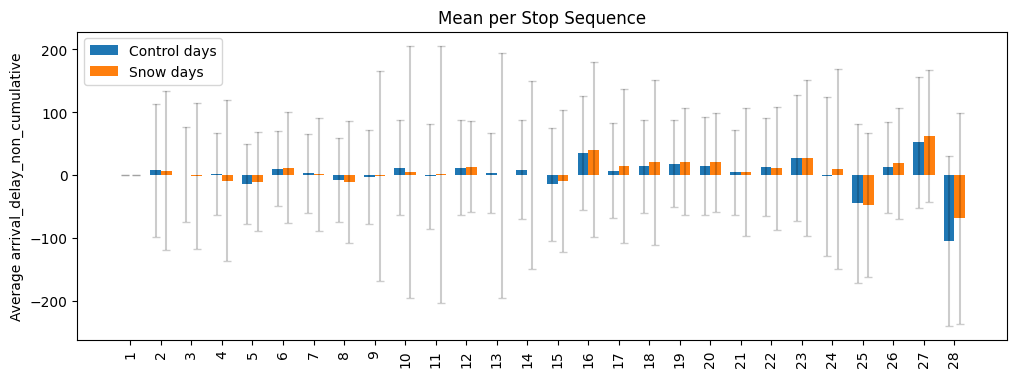

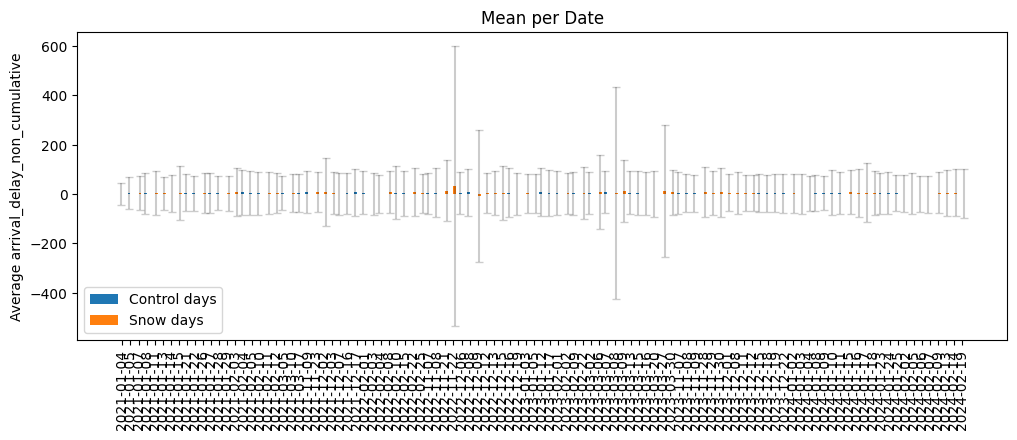


Average arrival_delay_non_cumulative and std - Weekday level:
                            mean         std
weekday   day_type                          
Friday    Control days  3.887775   81.744443
          Snow days     3.475302  115.252305
Monday    Control days  2.919868   81.642161
          Snow days     6.773575  122.797807
Thursday  Control days  4.760751   85.784044
          Snow days     4.768325   93.530544
Tuesday   Control days  4.324407   83.543645
          Snow days     6.755207  150.918888
Wednesday Control days  3.809133   83.244525
          Snow days     5.094893  156.017660

T-tests for Weekday level:
Friday: p = 0.7914
Monday: p = 0.0504
Thursday: p = 0.9951
Tuesday: p = 0.1677
Wednesday: p = 0.5287


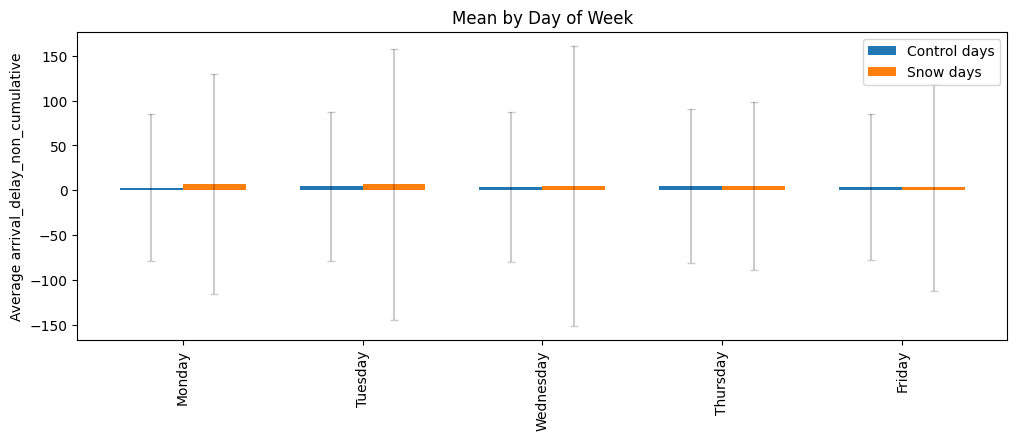


Average arrival_delay_non_cumulative and std - Hourly level:
                        mean         std
hour day_type                           
6    Control days   0.323368   70.533660
     Snow days      0.781129  183.876268
7    Control days   4.665073   80.227222
     Snow days      2.828417  112.776701
8    Control days   3.983116   88.731829
     Snow days      8.791034  133.362130
9    Control days  -8.528302  204.790099
     Snow days     57.389381  382.686706

T-tests for Hourly level:
6: p = 0.9052
7: p = 0.0494
8: p = 0.0001
9: p = 0.1510


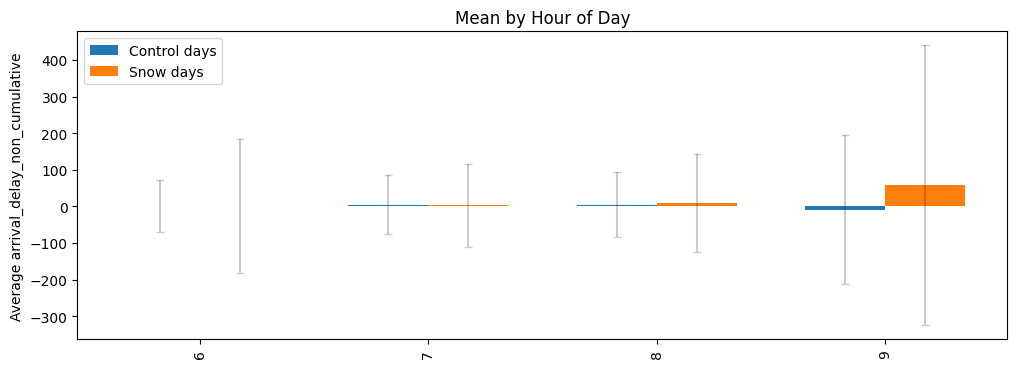


Average arrival_delay_non_cumulative and std - Yearly level:
                       mean         std
year day_type                          
2021 Control days  4.260484   80.431035
     Snow days     5.149377   87.194224
2022 Control days  4.701411   91.270561
     Snow days     5.815691  182.985674
2023 Control days  4.162445   85.067133
     Snow days     6.010847  148.581013
2024 Control days  3.108174   78.623619
     Snow days     4.112145   92.159939

T-tests for Yearly level:
2021: p = 0.3713
2022: p = 0.6351
2023: p = 0.2461
2024: p = 0.4470


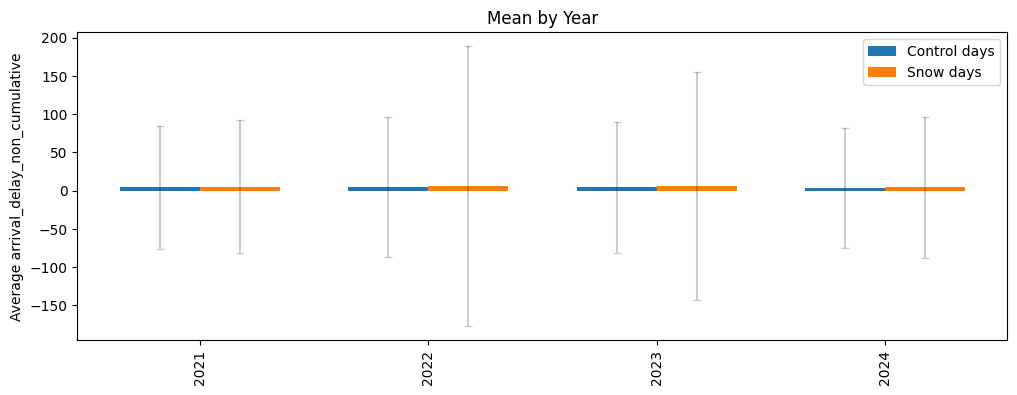

In [15]:
delay_analysis(dedup_snow, dedup_control, 'arrival_delay_non_cumulative')

## Mapping arrival delay

In [18]:
def separate_directions(df):
  stop1_ids = df[(df['stop_name'] == 'Radiohuset') & (df['stop_sequence'] == 1)]['trip_day_id']
  stop2_ids = df[(df['stop_name'] == 'Gullmarsplan') & (df['stop_sequence'] == 1)]['trip_day_id']

  df_stop1 = df[df['trip_day_id'].isin(stop1_ids)]
  df_stop2 = df[df['trip_day_id'].isin(stop2_ids)]

  df_stop1['arrival_delay'] = df_stop1['arrival_delay'] / 60
  df_stop2['arrival_delay'] = df_stop2['arrival_delay'] / 60

  return df_stop1, df_stop2

In [19]:
snow_radio, snow_gullis = separate_directions(dedup_snow)
control_radio, control_gullis = separate_directions(dedup_control)

<ipython-input-18-478316d7c125>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stop1['arrival_delay'] = df_stop1['arrival_delay'] / 60
<ipython-input-18-478316d7c125>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stop2['arrival_delay'] = df_stop2['arrival_delay'] / 60


In [20]:
means_snow_radio = snow_radio.groupby('stop_name').agg({'arrival_delay': 'mean','lat': 'first','lon': 'first'}).reset_index()
means_snow_gullis = snow_gullis.groupby('stop_name').agg({'arrival_delay': 'mean','lat': 'first','lon': 'first'}).reset_index()
means_control_radio = control_radio.groupby('stop_name').agg({'arrival_delay': 'mean','lat': 'first','lon': 'first'}).reset_index()
means_control_gullis = control_gullis.groupby('stop_name').agg({'arrival_delay': 'mean','lat': 'first','lon': 'first'}).reset_index()

gdf_snow_radio  = gpd.GeoDataFrame(means_snow_radio,geometry=gpd.points_from_xy(means_snow_radio['lon'], means_snow_radio['lat']),crs='EPSG:4326').to_crs(epsg=3857)
gdf_snow_gullis = gpd.GeoDataFrame(means_snow_gullis,geometry=gpd.points_from_xy(means_snow_gullis['lon'], means_snow_gullis['lat']),crs='EPSG:4326').to_crs(epsg=3857)
gdf_control_radio = gpd.GeoDataFrame(means_control_radio,geometry=gpd.points_from_xy(means_control_radio['lon'], means_control_radio['lat']),crs='EPSG:4326').to_crs(epsg=3857)
gdf_control_gullis = gpd.GeoDataFrame(means_control_gullis,geometry=gpd.points_from_xy(means_control_gullis['lon'], means_control_gullis['lat']),crs='EPSG:4326').to_crs(epsg=3857)

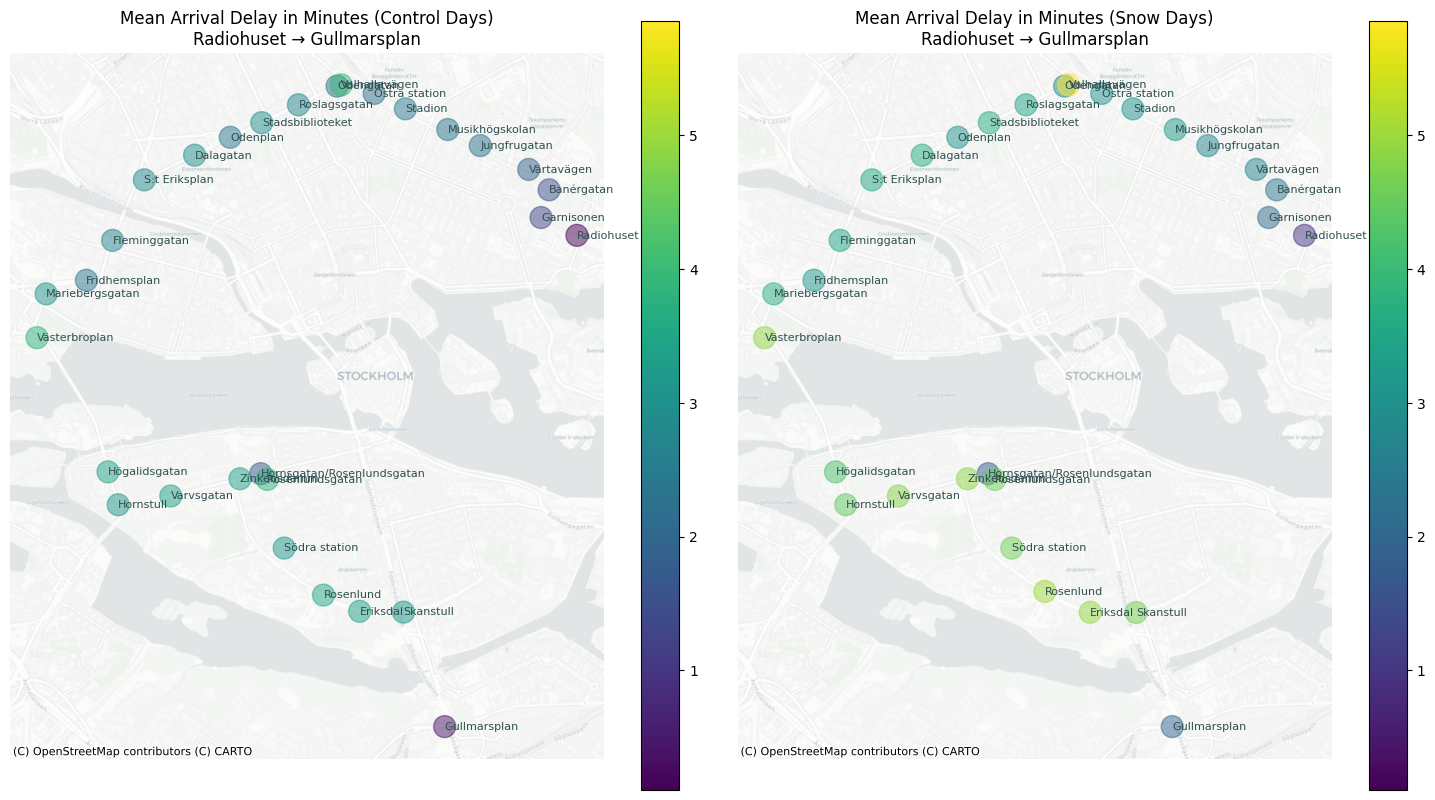

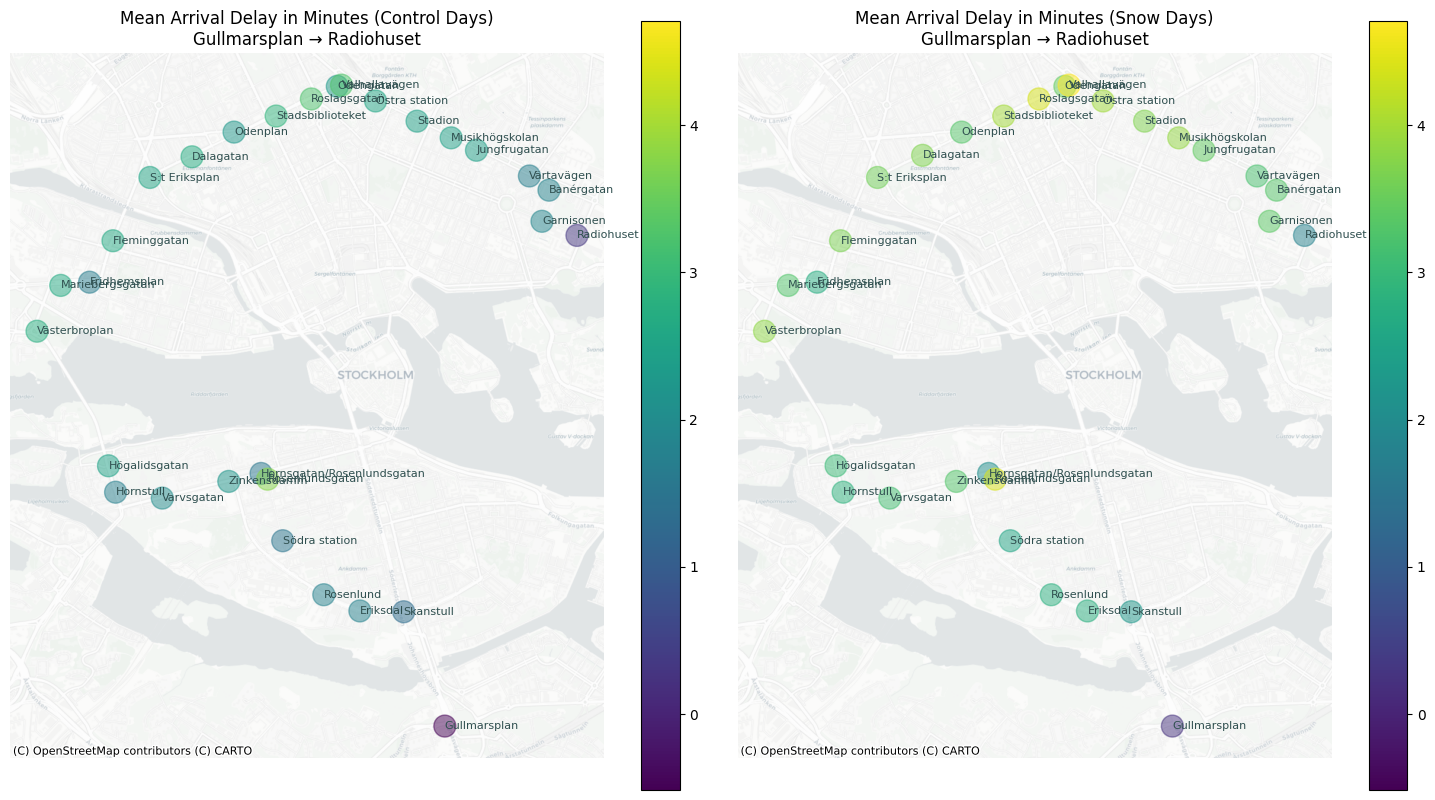

In [21]:
for dir_i, gdf in enumerate([[gdf_snow_radio, gdf_control_radio], [gdf_snow_gullis, gdf_control_gullis]]):
    gdf_snow, gdf_control = gdf
    fig, axes = plt.subplots(1, 2, figsize=(15, 8))
    dim = 'arrival_delay'

    vmin = min(gdf_snow[dim].min(), gdf_control[dim].min())
    vmax = max(gdf_snow[dim].max(), gdf_control[dim].max())

    for i, (gdf, title) in enumerate(zip([gdf_control, gdf_snow], ['Control Days', 'Snow Days'])):
        ax = gdf.plot(ax=axes[i], column=dim, legend=True, alpha=0.5, vmin=vmin, vmax=vmax, markersize=250)
        for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf['stop_name']):
          ax.text(x, y, label, fontsize=8, ha='left', va='center', color='darkslategrey')
        ctx.add_basemap(ax, crs=gdf.crs, source=ctx.providers.CartoDB.Positron, alpha=0.7)
        direction = 'Radiohuset → Gullmarsplan' if dir_i == 0 else 'Gullmarsplan → Radiohuset'
        ax.set_title(f'Mean Arrival Delay in Minutes ({title})\n{direction}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [22]:
def compute_difference_gdf(means_snow, means_control):
    diff_df = pd.merge(means_snow[['stop_name', 'arrival_delay', 'lat', 'lon']], means_control[['stop_name', 'arrival_delay']], on='stop_name', suffixes=('_snow', '_control'))
    diff_df['delay_diff'] = (diff_df['arrival_delay_snow'] - diff_df['arrival_delay_control']) * 60
    gdf_diff = gpd.GeoDataFrame(
        diff_df,
        geometry=gpd.points_from_xy(diff_df['lon'], diff_df['lat']),
        crs='EPSG:4326'
    ).to_crs(epsg=3857)
    return gdf_diff

In [23]:
gdf_diff_radio = compute_difference_gdf(means_snow_radio, means_control_radio)
gdf_diff_gullis = compute_difference_gdf(means_snow_gullis, means_control_gullis)

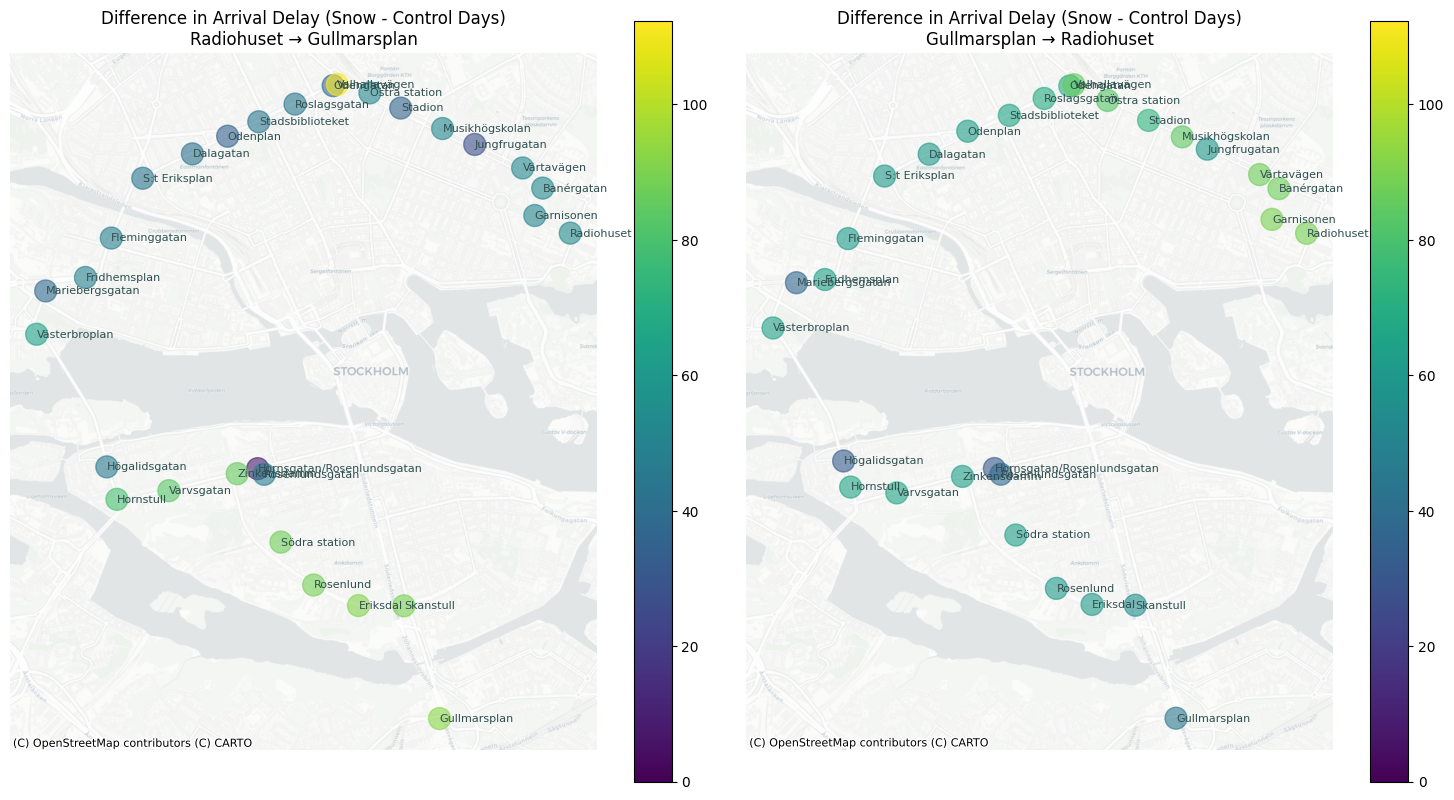

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
dim = 'arrival_delay'
titles = ['Radiohuset → Gullmarsplan', 'Gullmarsplan → Radiohuset']

for i, (gdf_diff, ax) in enumerate(zip([gdf_diff_radio, gdf_diff_gullis], axes)):
    gdf_diff.plot(
        ax=ax,
        column='delay_diff',
        legend=True,
        cmap='viridis',
        alpha=0.6,
        markersize=250,
        vmin=0, #min(abs(gdf_diff_radio['delay_diff']).min(), abs(gdf_diff_gullis['delay_diff']).min()),
        vmax=max(abs(gdf_diff_radio['delay_diff']).max(), abs(gdf_diff_gullis['delay_diff']).max())
    )

    for x, y, label in zip(gdf_diff.geometry.x, gdf_diff.geometry.y, gdf_diff['stop_name']):
        ax.text(x, y, label, fontsize=8, ha='left', va='center', color='darkslategrey')

    ctx.add_basemap(ax, crs=gdf_diff.crs, source=ctx.providers.CartoDB.Positron, alpha=0.7)
    ax.set_title(f'Difference in Arrival Delay (Snow - Control Days)\n{titles[i]}')
    ax.axis('off')

plt.tight_layout()
plt.show()